In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv('../../../data/processed/tokenized_data.csv')
X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], df['overall'], test_size=0.2, random_state=42)

y_train = y_train - 1
y_test = y_test -1

X_train.fillna('', inplace=True)
X_test.fillna('', inplace=True)

# Initialize and fit the CountVectorizer to transform text data into bag-of-words vectors
vectorizer = CountVectorizer()

X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=5, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

In [13]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=5, random_state=42)

xgb_model.fit(X_train_bow, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=5,
              num_parallel_tree=None, ...)

In [14]:
y_pred = xgb_model.predict(X_test_bow)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.70      0.64     20917
         1.0       0.33      0.07      0.11     12765
         2.0       0.39      0.29      0.33     19019
         3.0       0.47      0.27      0.34     28682
         4.0       0.74      0.93      0.82     88965

    accuracy                           0.66    170348
   macro avg       0.50      0.45      0.45    170348
weighted avg       0.61      0.66      0.61    170348



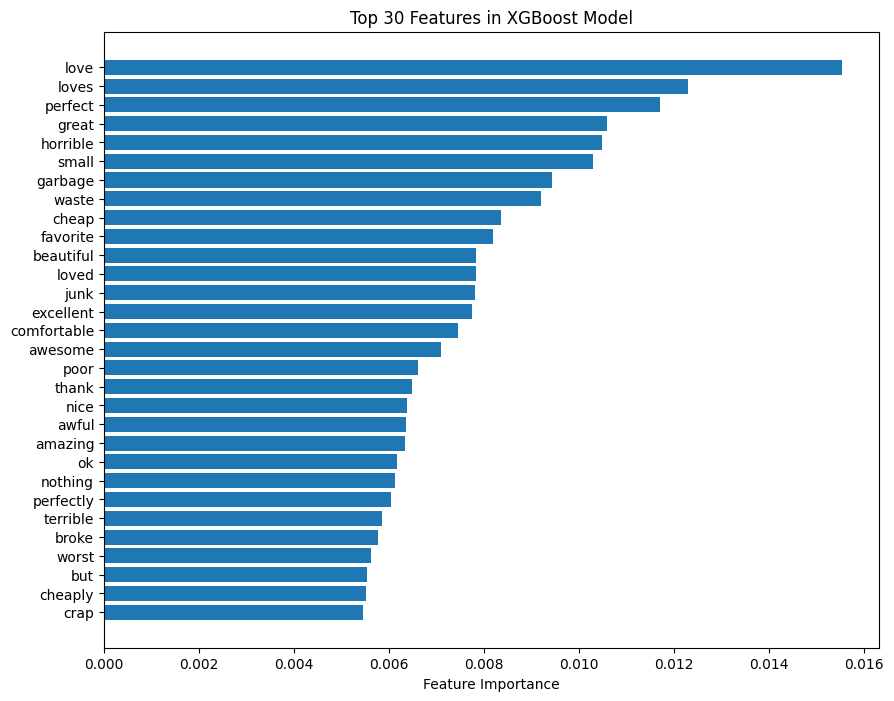

In [19]:
feature_names = vectorizer.get_feature_names_out()

# Get the feature importances from the XGBoost model
importances = xgb_model.feature_importances_

# Create a list of (feature_name, importance) tuples
features_importances = zip(feature_names, importances)

# Sort the features by their importance
sorted_features = sorted(features_importances, key=lambda x: -abs(x[1]))

# Select the top 30 features
top_features = sorted_features[:30]

# Separate the feature names and their importances
top_feature_names, top_importances = zip(*top_features)

# Create a bar chart
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Top 30 Features in XGBoost Model')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest value on top
plt.show()


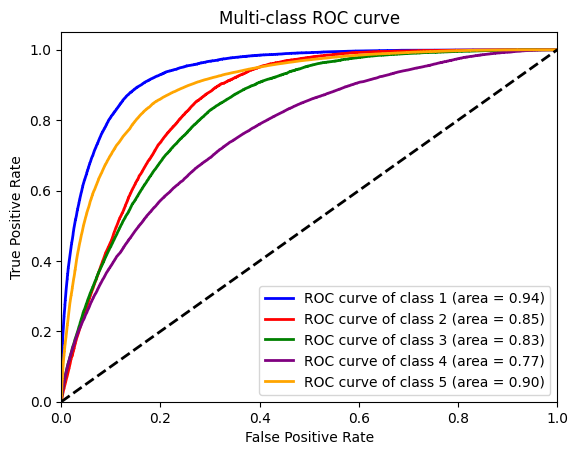

In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output labels for multi-class ROC curve
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

# Calculate dummies once
y_pred_proba = xgb_model.predict_proba(X_test_bow)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i + 1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve')
plt.legend(loc="lower right")
plt.show()